In [1]:
#### Import necessary libraries ####

# Machine Learning library 
import tensorflow as tf 
# Library for OS commands such as delete files
import os 
# Check file extensions of images
import imghdr 
# You know it from the lecture
import cv2 
import numpy as np 
from matplotlib import pyplot as plt

# Deep Learning
# Sequential API --> 1 input, 1 output; there's a Functional API too for more complex tasks
from tensorflow.keras.models import Sequential 
# Layer import: 
# Conv2D --> Convolutional layer
# MaxPooling2D --> Condensing layer 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# Visualize model 
import visualkeras
from PIL import ImageFont


# Evaluation and testing 
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
# For saving the model
from tensorflow.keras.models import load_model 


# Notes
# This coding example is based on "Build a Deep CNN Image Classifier with ANY Images" 
# by Nicholas Renotte (https://www.youtube.com/watch?v=jztwpsIzEGc). This notebook contains comments 
# and modifications. It is used for a presentation on "Maschinelle Wahrnehmung" (Machine Perception)
# held by Annika Scherer on 27. May 2023. The topic of the presentation is "Klassifizierung mittels eines tiefen
# neuronalen Netzes" (Classification with a deep neural network).



In [2]:
# Clean up data downloaded from web 
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [3]:
# Load trainingsdata, builds image dataset, preprocessing 
# --> builds labels and classes; creates consistent size (resize images) and batches them up
# query the help topic as shown in above help to configure the command
data = tf.keras.utils.image_dataset_from_directory('data') 
data


Found 528 files belonging to 2 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
# Allow us to create batches of data, iterates through data pipeline
data_iterator = data.as_numpy_iterator()

In [5]:
# Access data pipeline itself, grabbing a batch of data 
# Run again to get another batch from the iterator
batch = data_iterator.next()
len(batch) # tuple: image representation as numpy array, label

2

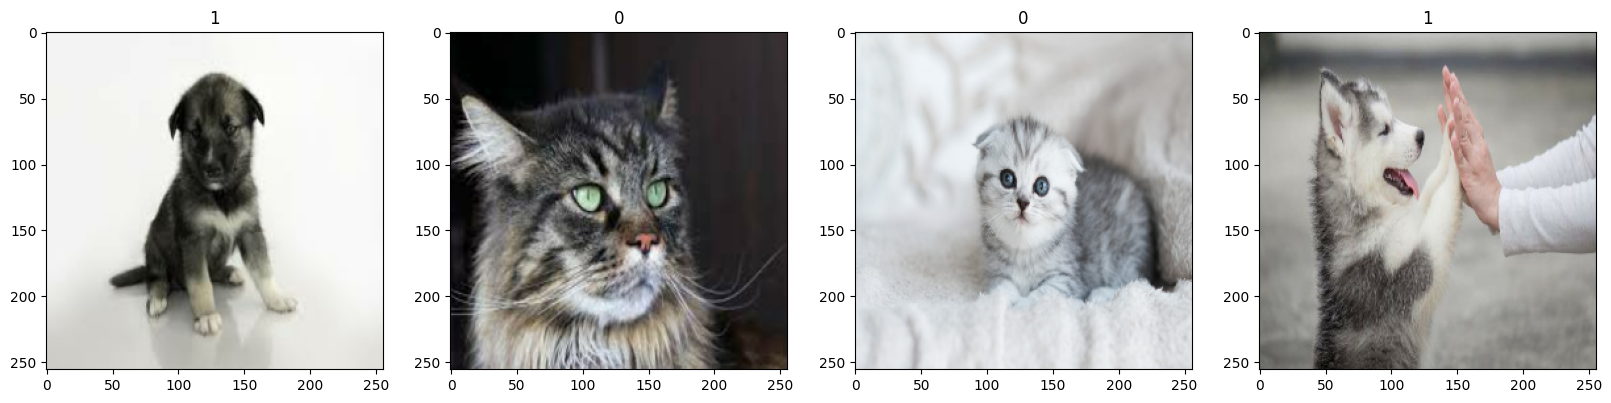

In [6]:
# visualization 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
# Note
# We have two folders, the first contains kittens, the second contains puppies. 
# Based on this we were able to label the data that we collected from the Google picture search. 
# class 0 --> kitten 
# class 1 --> puppy 

In [7]:
# Scale data --> Why?
# https://analyticsindiamag.com/why-data-scaling-is-important-in-machine-learning-how-to-effectively-do-it/
# Chances are better to train the model better and faster
# --> Accuracy is higher when the difference between the data values is lower
# Modify the dataset so the image representations are values between 0.0 and 1.0 
data = data.map(lambda x,y: (x/255, y)) 

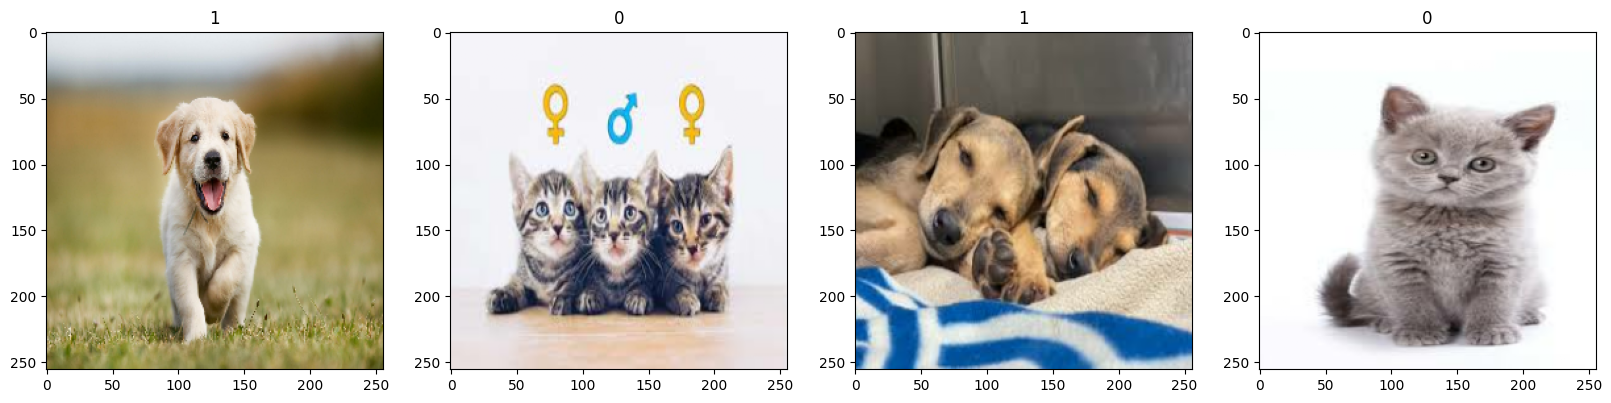

In [8]:
# Grab next batch
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
#batch[0].min()

# Visualization 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) # do not convert to int here because our values are between 0.0 and 1.0
    ax[idx].title.set_text(batch[1][idx])

In [9]:
train_size = int(len(data)*0.7) # training set = 70 % of our data --> data partition that is used for training the model
val_size = int(len(data)*0.2) +1# validation set = 20 % of our data --> data used to evaluate model while training
test_size = int(len(data)*0.1)+1 # ONLY used at the end! --> post training

print("Train size: {0}\nVal size: {1}\nTest size: {2}\n".format(train_size, val_size, test_size))
print("Sum of partitions: {0}\nPartitions of dataset: {1}".format(train_size+val_size+test_size, len(data)))

Train size: 11
Val size: 4
Test size: 2

Sum of partitions: 17
Partitions of dataset: 17


In [10]:
# Allocate partitions with TensorFlow
# Take specified amount of batches out of our data pipeline
train = data.take(train_size) 
# Skip the training data and take the next batches
val = data.skip(train_size).take(val_size) 
# Skip training and validation data and take the last batch(es)
test = data.skip(train_size+val_size).take(test_size) 

print("Train: {0}\nVal: {1}\nTest: {2}\n".format(len(train), len(val), len(test)))

Train: 11
Val: 4
Test: 2



In [11]:
# Deep Learning starts here --> create instance of Sequential class
model = Sequential()

In [12]:
# Chain the layers, create architecture of the model
# Input layer: Convolutional with 16 filters, extract relevant information inside an image to make an
# output classification
# Number of filters: 16; Filter size: 3x3; Stepsize: 1 pixel
# ReLU activation function: negative values equal zero, positive remain unchanged
# Input shape = default shape of our tf.keras.utils.image_dataset_from_directory function 
# --> width, height equal 256, 3 channels 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Condense/compress information down
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
# Output Layer: 1 Output value that is either 1 or 0 --> sigmoid activation
model.add(Dense(1, activation='sigmoid'))

In [13]:
# Gradient descent: Adam; Binary loss --> kitten or puppy; Accuracy: evaluate how well our model is classifying
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) 

In [14]:
# Summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

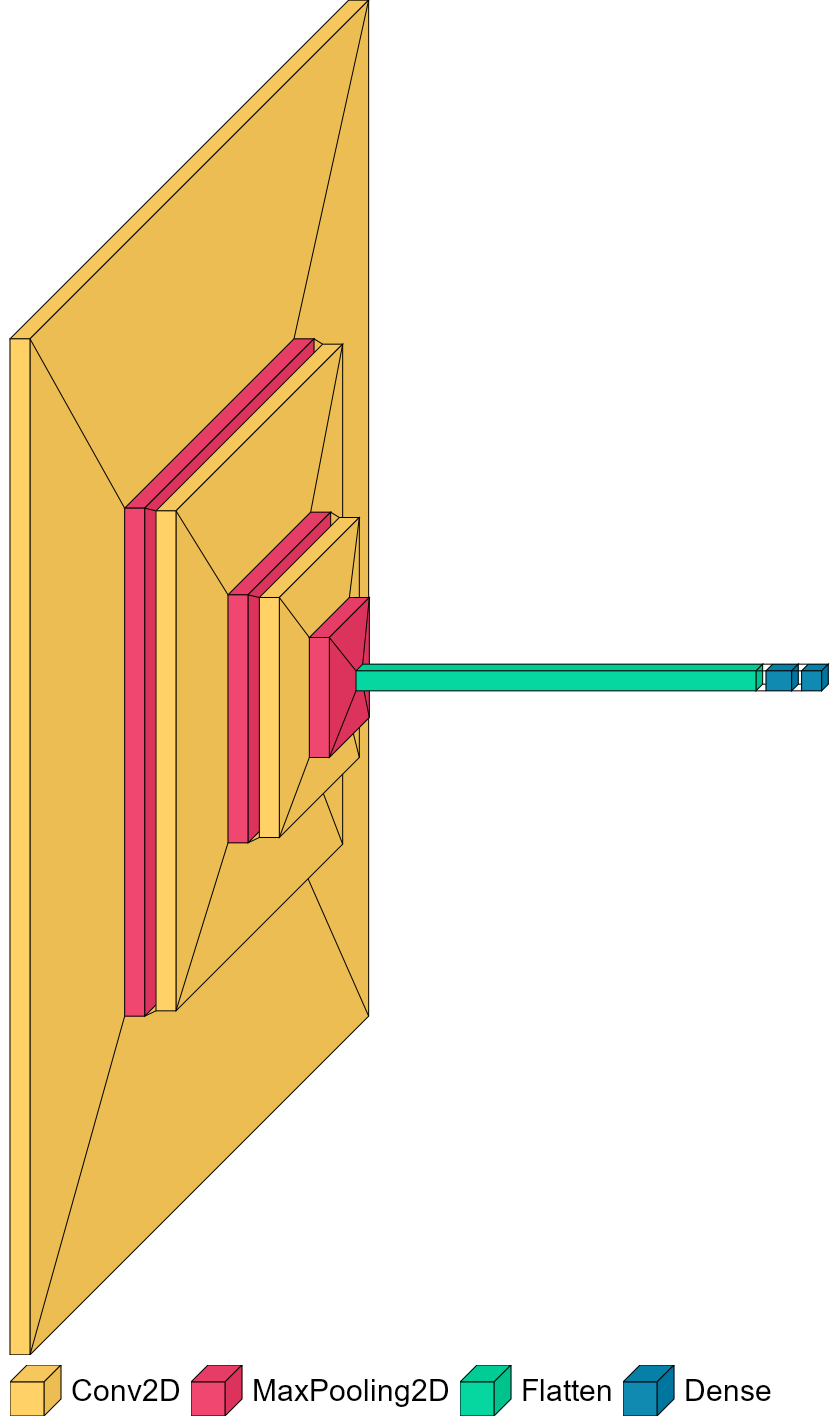

In [15]:
# Visualize the model
# https://analyticsindiamag.com/how-to-visualize-deep-learning-models-using-visualkeras/
font = ImageFont.truetype("arial.ttf", 30)
visualkeras.layered_view(model, legend=True, font=font)

In [16]:
# Point to logs directory 
logdir="logs"

In [17]:
# Set log
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:
# The actual training happens here
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

# Goal: decrease loss, increase accuracy 

Epoch 1/30
11/11 [==============================] - 9s 747ms/step - loss: 0.9211 - accuracy: 0.4716 - val_loss: 0.6871 - val_accuracy: 0.6094
Epoch 2/30
11/11 [==============================] - 10s 842ms/step - loss: 0.6834 - accuracy: 0.5597 - val_loss: 0.6742 - val_accuracy: 0.5703
Epoch 3/30
11/11 [==============================] - 10s 874ms/step - loss: 0.6919 - accuracy: 0.5256 - val_loss: 0.6711 - val_accuracy: 0.5469
Epoch 4/30
11/11 [==============================] - 10s 838ms/step - loss: 0.6796 - accuracy: 0.5966 - val_loss: 0.6621 - val_accuracy: 0.6641
Epoch 5/30
11/11 [==============================] - 10s 848ms/step - loss: 0.6666 - accuracy: 0.5966 - val_loss: 0.6509 - val_accuracy: 0.6562
Epoch 6/30
11/11 [==============================] - 11s 903ms/step - loss: 0.6349 - accuracy: 0.6477 - val_loss: 0.6480 - val_accuracy: 0.6250
Epoch 7/30
11/11 [==============================] - 12s 1s/step - loss: 0.6493 - accuracy: 0.6364 - val_loss: 0.6173 - val_accuracy: 0.7109
Epo

In [19]:
# output the data in hist --> delivers values for each epoch 
hist.history

{'loss': [0.9210624098777771,
  0.6834232211112976,
  0.691946268081665,
  0.6795778870582581,
  0.666626513004303,
  0.6348609924316406,
  0.6492876410484314,
  0.6177470684051514,
  0.5745653510093689,
  0.5383597016334534,
  0.45891904830932617,
  0.4050661325454712,
  0.313761830329895,
  0.28897014260292053,
  0.2526724338531494,
  0.17871800065040588,
  0.169047012925148,
  0.10557686537504196,
  0.08988047391176224,
  0.06926048547029495,
  0.05410683527588844,
  0.03617333993315697,
  0.04157187417149544,
  0.03224344924092293,
  0.017375245690345764,
  0.012852948158979416,
  0.008162849582731724,
  0.007367180194705725,
  0.0053374748677015305,
  0.004119365941733122],
 'accuracy': [0.47159090638160706,
  0.5596590638160706,
  0.5255681872367859,
  0.5965909361839294,
  0.5965909361839294,
  0.6477272510528564,
  0.6363636255264282,
  0.7272727489471436,
  0.7329545617103577,
  0.7272727489471436,
  0.8181818127632141,
  0.8607954382896423,
  0.8863636255264282,
  0.909090936

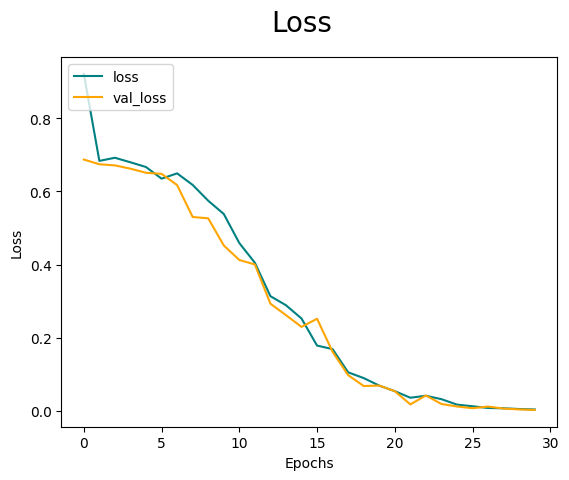

In [20]:
# Plot information from training
# Loss: decreases over time, validation loss looks good too, if it would increase again over time --> sign for overfitting
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

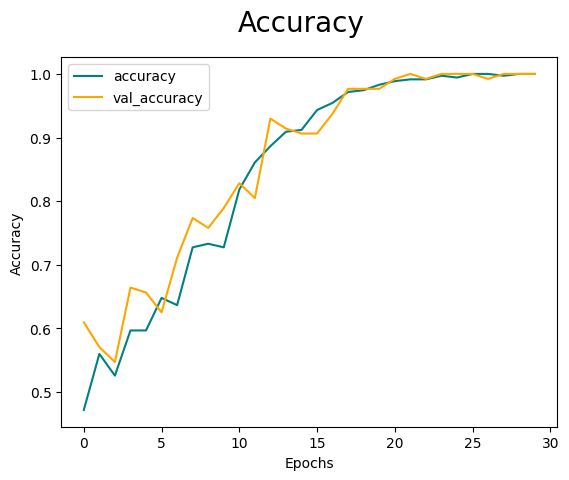

In [45]:
# Accuracy: increases over time --> good sign
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

In [22]:
# Evaluation of Performance
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

len(test)

2

In [23]:
# We evaluate here how good our model predicts output values post training
for batch in test.as_numpy_iterator(): # iterate through all test batches
    X, y = batch # X: set of images, y: label
    yhat = model.predict(X) # model predicts a label for the image
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print("Precision: {0}\nRecall: {1}\nAccuracy: {2}".format(pre.result().numpy(), re.result().numpy(), acc.result().numpy()))

1/1 [==============================] - 0s 141ms/step
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


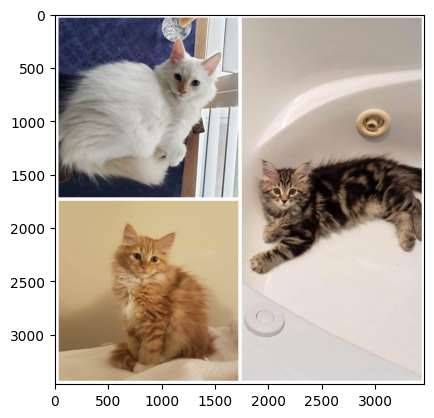

In [52]:
# Test the model
img = cv2.imread('holy_trinity.jpg')
# img = cv2.imread('doggos.jpg')
# img = cv2.imread('_penny.jpg')
# img = cv2.imread('_chouchou.jpg')
# img = cv2.imread('_ponpon.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()

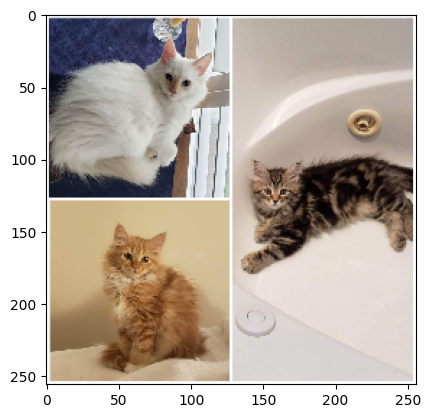

In [53]:
# Plot after resize
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [54]:
# Predict the image from above, expand array dimension and scale
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat[0])

# Set threshold
if yhat > 0.5: 
    print("Predicted class: Puppy")
else:
    print("Predicted class: Kitten")

1/1 [==============================] - 0s 29ms/step
[0.02905159]
Predicted class: Kitten


In [32]:
# Saving the model
# model.save(os.path.join('models','classifyer_puppies_and_kitties.h5'))

In [28]:
# Loading saved model
# new_model = load_model(os.path.join('models', 'classifyer_puppies_and_kitties.h5'))
# img = cv2.imread('doggos.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# plt.imshow(img)
# resize = tf.image.resize(img, (256,256))
# plt.show()

# yhat_new = new_model.predict(np.expand_dims(resize/255, 0))
# print(yhat_new[0])
# # Set threshold
# if yhat_new > 0.5: 
#     print("Predicted class: Puppy")
# else:
#     print("Predicted class: Kitten")